<a href="https://colab.research.google.com/github/e-c-centric/Group26_Final_Project/blob/main/Group26_Final_Project.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install textstat langid

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 105.1/105.1 kB 3.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.9/1.9 MB 20.3 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 27.8 MB/s eta 0:00:00
  Created wheel for langid: filename=langid-1.1.6-py3-none-any.whl size=1941172 sha256=4e920a13d4fa431d020ffa204eb13ac23faab67877966add6c8819dcd5478e23
  Stored in directory: /root/.cache/pip/wheels/23/c8/c6/eed80894918490a175677414d40bd7c851413bbe03d4856c3c
Successfully built langid


In [2]:
import pandas as pd
import numpy as np
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.cluster import KMeans
from google.colab import drive
from sklearn.preprocessing import StandardScaler, LabelEncoder, OneHotEncoder
import random
import textstat
import langid
from sklearn.model_selection import train_test_split
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import accuracy_score, classification_report
from gensim.models import Word2Vec
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
import matplotlib.pyplot as plt

In [3]:
drive.mount('/content/drive')

Mounted at /content/drive


In [4]:
file_path = '/content/drive/MyDrive/Colab Notebooks/words.txt'

with open(file_path, 'r') as file:
    words = file.read().split()

refined_words = [word for word in words if word.isalpha() and len(word) >= 3]

with open('/content/drive/MyDrive/Colab Notebooks/application_words.txt', 'w') as file:
    file.write('\n'.join(refined_words))

random_sample = random.sample(refined_words, 1000)
with open('/content/drive/MyDrive/Colab Notebooks/training_words.txt', 'w') as file:
    file.write('\n'.join(random_sample))

In [5]:
file_path = '/content/drive/MyDrive/Colab Notebooks/training_words.txt'
training_df = pd.read_csv(file_path, sep= " ", names=['word'])
training_df = training_df.dropna()

file_path = '/content/drive/MyDrive/Colab Notebooks/application_words.txt'
application_df = pd.read_csv(file_path, sep= " ", names=['word'])
application_df = application_df.dropna()

In [6]:
training_df.info

<bound method DataFrame.info of                word
0            yabble
1        meloplasty
2        fisherfolk
3          officina
4        disfavored
..              ...
995  astronavigator
996        Vertrees
997     necrobiosis
998         citrine
999         Belknap

[1000 rows x 1 columns]>

In [7]:
application_df.info

<bound method DataFrame.info of                 word
0                AAA
1               AAAA
2             AAAAAA
3               AAAL
4               AAAS
...              ...
415696  zwitterionic
415697        Zwolle
415698      Zworykin
415699           zZt
415700           ZZZ

[415700 rows x 1 columns]>

In [8]:
def extract_features(word):
    try:
        syllables = textstat.syllable_count(word)
        ari = textstat.automated_readability_index(word)
        length = len(word)
        language, _ = langid.classify(word)

        return {'syllables': syllables, 'ari': ari, 'length': length, 'language': language}
    except Exception as e:
        # Handle exceptions for words that might cause issues with the calculations
        print(f"Error extracting features for '{word}': {e}")
        return None


feature_columns = ['ari','length']
for column in feature_columns:
    training_df[column] = training_df['word'].apply(lambda word: extract_features(word)[column] if extract_features(word) else None)

# Drop rows with missing features
training_df = training_df.dropna(subset=feature_columns)

In [9]:
training_df.tail()

,word,ari,length
995,astronavigator,45.0,14
996,Vertrees,16.8,8
997,necrobiosis,30.9,11
998,citrine,12.0,7
999,Belknap,12.0,7


In [10]:
word2vec_model = Word2Vec(sentences=[training_df['word'].tolist()], vector_size=100, window=5, min_count=1, workers=4)

def word_to_vec(word):
    try:
        return word2vec_model.wv[word]
    except KeyError:
        return None

training_df['word_vector'] = training_df['word'].apply(word_to_vec)

training_df = training_df.dropna(subset=['word_vector'])

In [11]:
'''unique_elements = training_df['language'].unique()

print(unique_elements)'''

"unique_elements = training_df['language'].unique()\n\nprint(unique_elements)"

In [12]:
'''label_encoder = LabelEncoder()
training_df['language'] = label_encoder.fit_transform(training_df['language'])'''

"label_encoder = LabelEncoder()\ntraining_df['language'] = label_encoder.fit_transform(training_df['language'])"

In [13]:
scaler = StandardScaler()

X_train_word_vector = np.stack(training_df['word_vector'].to_numpy())
X_train_other_features = scaler.fit_transform(training_df[feature_columns])

X_train = np.concatenate((X_train_word_vector, X_train_other_features), axis=1)

In [14]:
training_df

,word,ari,length,word_vector
0,yabble,7.3,6,"[0.005925518, 0.0087031275, 0.0003765543, 0.00..."
1,meloplasty,26.2,10,"[-0.00030028366, 0.006692016, -0.0012418592, 0..."
2,fisherfolk,26.2,10,"[0.0089151785, 0.0012755938, 0.0023683587, 0.0..."
3,officina,16.8,8,"[0.006089293, -0.0037594798, -0.0039216885, 0...."
4,disfavored,26.2,10,"[-0.0005920146, 0.008530728, -0.0076952623, -0..."
...,...,...,...,...
995,astronavigator,45.0,14,"[0.0042124446, -0.001107116, -0.0067173527, 0...."
996,Vertrees,16.8,8,"[0.001545189, 0.006262725, -0.00760414, 0.0047..."
997,necrobiosis,30.9,11,"[-0.005695761, 0.008804434, 0.009007973, 0.006..."
998,citrine,12.0,7,"[0.0019916962, 0.008293148, -0.008286478, -0.0..."


In [15]:
X_train

array([[ 5.92551799e-03,  8.70312750e-03,  3.76554293e-04, ...,
         7.00567989e-03, -1.13495780e+00, -1.13316243e+00],
       [-3.00283660e-04,  6.69201603e-03, -1.24185917e-03, ...,
         7.24821212e-03,  2.43524597e-01,  2.42034693e-01],
       [ 8.91517848e-03,  1.27559376e-03,  2.36835866e-03, ...,
        -9.65510868e-03,  2.43524597e-01,  2.42034693e-01],
       ...,
       [-5.69576118e-03,  8.80443398e-03,  9.00797267e-03, ...,
        -2.35904101e-03,  5.86321808e-01,  5.85833973e-01],
       [ 1.99169619e-03,  8.29314813e-03, -8.28647800e-03, ...,
         5.88677591e-03, -7.92160593e-01, -7.89363146e-01],
       [-5.51932550e-04,  2.52453348e-04,  5.10447146e-03, ...,
         6.39427407e-03, -7.92160593e-01, -7.89363146e-01]])

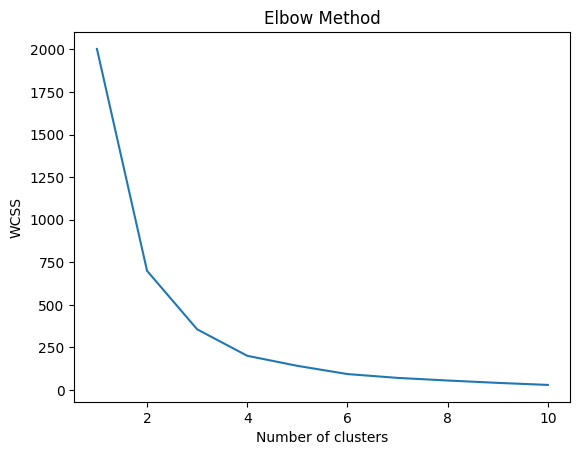

In [16]:
wcss = []

for i in range(1, 11):
    kmeans = KMeans(n_clusters=i, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans.fit(X_train)
    wcss.append(kmeans.inertia_)

plt.plot(range(1, 11), wcss)
plt.title('Elbow Method')
plt.xlabel('Number of clusters')
plt.ylabel('WCSS')
plt.show()

optimal_clusters = 16

kmeans = KMeans(n_clusters=optimal_clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
training_df['cluster'] = kmeans.fit_predict(X_train)

In [17]:
training_df

,word,ari,length,word_vector,cluster
0,yabble,7.3,6,"[0.005925518, 0.0087031275, 0.0003765543, 0.00...",10
1,meloplasty,26.2,10,"[-0.00030028366, 0.006692016, -0.0012418592, 0...",2
2,fisherfolk,26.2,10,"[0.0089151785, 0.0012755938, 0.0023683587, 0.0...",2
3,officina,16.8,8,"[0.006089293, -0.0037594798, -0.0039216885, 0....",0
4,disfavored,26.2,10,"[-0.0005920146, 0.008530728, -0.0076952623, -0...",2
...,...,...,...,...,...
995,astronavigator,45.0,14,"[0.0042124446, -0.001107116, -0.0067173527, 0....",7
996,Vertrees,16.8,8,"[0.001545189, 0.006262725, -0.00760414, 0.0047...",0
997,necrobiosis,30.9,11,"[-0.005695761, 0.008804434, 0.009007973, 0.006...",6
998,citrine,12.0,7,"[0.0019916962, 0.008293148, -0.008286478, -0.0...",8


In [18]:
silhouette_avg = silhouette_score(X_train, training_df['cluster'])
print(f"Silhouette Score: {silhouette_avg}")

Silhouette Score: 0.8304450539225393
